### Import Libraries

In [20]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F 

import matplotlib.pyplot as plt
import time

from tqdm import tqdm

### Load checkpoint

In [21]:
checkpoint = torch.load('checkpoint.tar')

### Create data loaders

In [22]:
transform = checkpoint['transforms']
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Create the same model

In [23]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

        
        
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()
    
    running_loss = 0
    
    #pbar = tqdm(enumerate(train_loader), total = len(train_loader)+1)
    
    for (imgs, labels) in train_loader:
        imgs = imgs.view(imgs.shape[0], -1) #since we have a flat network right now
        
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss+= loss.item()
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch, running_loss/len(train_loader)))
    
    return running_loss/len(train_loader)
        
def valid_one_epoch(epoch, model, loss_fn, test_loader):
    model.eval()
    
    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    
    for (imgs, labels) in test_loader:
        imgs = imgs.view(imgs.shape[0], -1) #since we have a flat network right now
        
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)
        
        
        preds = torch.exp(log_preds)
        running_loss+=loss.item()
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).numpy())
        actual_labels+= list(labels.numpy())
        
        
    
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/10000 #size of test set
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch, running_loss/len(test_loader)))
    print('Epoch {} Valid accuracy: {:.1%}\n'.format(epoch, accuracy))
    
    return running_loss/len(test_loader)
    
        

In [26]:
#create the same network
model = Network()

#load the dictionary
model.load_state_dict(checkpoint['model_state_dict'])

loss_fn = checkpoint['loss']

optimizer = optim.Adam(model.parameters(), lr = 0.003)
#load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

### Resuming Training

In [27]:
print('Trained for {} epochs\nResuming Training---->'.format(last_epoch))
train_losses = []
valid_losses = []
for epoch in range(last_epoch,last_epoch+3):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, trainloader)
    train_losses+= [train_loss]
    valid_loss = valid_one_epoch(epoch, model, loss_fn, testloader)
    valid_losses+=[valid_loss]
    
    

Trained for 10 epochs
Resuming Training---->
Epoch 10 avg Training loss: 0.380
Epoch 10 avg Valid loss: 0.429
Epoch 10 Valid accuracy: 85.1%

Epoch 11 avg Training loss: 0.391
Epoch 11 avg Valid loss: 0.421
Epoch 11 Valid accuracy: 85.5%

Epoch 12 avg Training loss: 0.379
Epoch 12 avg Valid loss: 0.392
Epoch 12 Valid accuracy: 86.3%



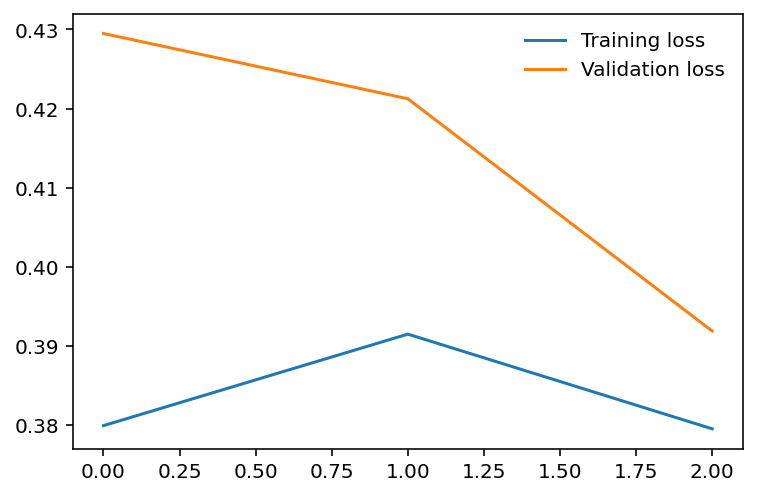

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)